### 0. Explicación de usos relevantes de la IA

El uso principal que hemos hecho de la IA es para poder entender el código o hacer lluvia de ideas de posibles soluciones.
Los cambios más significativos potenciados por la IA son.

*  **La reestructuración del código.**

Explicación:

El código anteriormente era muy dificil de comprender debido a que era una mezcla de código propio y código de los ejecicios de clase.

Qué se hizo:

Se decargó el cuaderno y se creó un script de python que extrallese el código se le pasó este código a ChatGPT con la instrucción de que lo ordenase. Luego este código se pegó cambiando algunas cosas para poder entender mejor la estructuración de este y quitar cosas innecesarias.
*   **La optimización del Árbol.**

Explicación:

El código de optimización del árbol no estaba funcionando bien y aun con cambio de las variables seguía sin mejorar.

Qué se hizo:

Se preguntó a ChatGPT posibles razones de la no mejora o posibles formas de mejorar.

Se preguntó:

* Si la relacion de las variables era lineal de forma que se pueda optimizar una y luego la otra ...

Respondio que no es posible.

* La posibilidad de que si se reduciera el cv hubiera menos overfiting

Respondio que esto es erroneo ya que no afecta a las épocas de entrenamiento.

* La posibilidad de que se evaluasen los modelos en un train_validation que no haya sido utilizado para el entrenamiento.

Verificó la posibilidad de hacerlo aun que la mejora es marginal.




### 1. Carga de datos y preprocesamiento (post eda)

In [82]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree, export_text
from sklearn.metrics import balanced_accuracy_score
import numpy as np

# Definir semilla
NIA = "100451061"
SEED = int(NIA[-2]) + int(NIA[-1])

# Cargar datos
df = pd.read_csv(f"/content/attrition_availabledata_0{SEED}.csv")

# Separar variables
X = df.drop(columns=["Attrition"])
y = df["Attrition"]

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=SEED, stratify=y)

Por la naturaleza desbalanceada del dataset, visto en la eda. (El porcentaje de si o no en la variable Attrition no es ~50%)

Es más util usar la exactitud balanceada que es la media entre el porcentaje de acierto en el si y el porcentaje de acierto en el no

### 2. Función para entrenar y evaluar modelos

In [77]:
# Esta función encapsula todo el fit de los splits de las variables, la predicción y la evaluación cruzada en uno
# Con el objetivo de automatizar estas acciones repetitivas y hacer que el código sea más legible
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, cv_folds=5, scoring='balanced_accuracy'):
    """Entrena un modelo, calcula su exactitud y realiza validación cruzada"""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = metrics.balanced_accuracy_score(y_test, y_pred)
    cv = KFold(n_splits=cv_folds, shuffle=True, random_state=SEED)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)

    print(f"\nModelo: {model.__class__.__name__}")
    print(f"Accuracy Balanceado: {acc:.2f}")
    print(f"Cross-validation mean: {scores.mean():.2f} ± {scores.std():.2f}")

    return model

### 3. Entrenamiento y Evaluación de KNN

In [78]:
#
knn_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

train_and_evaluate_model(knn_pipeline, X_train, y_train, X_test, y_test)



Modelo: Pipeline
Accuracy Balanceado: 0.59
Cross-validation mean: 0.62 ± 0.03


Pipeline(steps=[('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier())])

### 4. Optimización de hiperparámetros para KNN

In [79]:
# Creamos el modelo con todos los valores de vecinos desde 1 a 20 y evaluamos el mejor

param_grid_knn = {'knn__n_neighbors': range(1, 20)}
grid_knn = GridSearchCV(knn_pipeline, param_grid_knn, cv=5, scoring='balanced_accuracy')
grid_knn.fit(X_train, y_train)

print(f"\nMejor número de vecinos para KNN: {grid_knn.best_params_['knn__n_neighbors']}")

# Entrenar KNN con el mejor K encontrado
best_knn = grid_knn.best_estimator_
train_and_evaluate_model(best_knn, X_train, y_train, X_test, y_test)


Mejor número de vecinos para KNN: 1

Modelo: Pipeline
Accuracy Balanceado: 0.82
Cross-validation mean: 0.80 ± 0.02


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=1))])

Se observa una clara mejora de un 59% de acierto, casi una moneda, a un 82% de acierto.


### 5. Entrenamiento y Evaluación de Árbol de Decisión


Modelo: DecisionTreeClassifier
Accuracy Balanceado: 0.75
Cross-validation mean: 0.80 ± 0.02


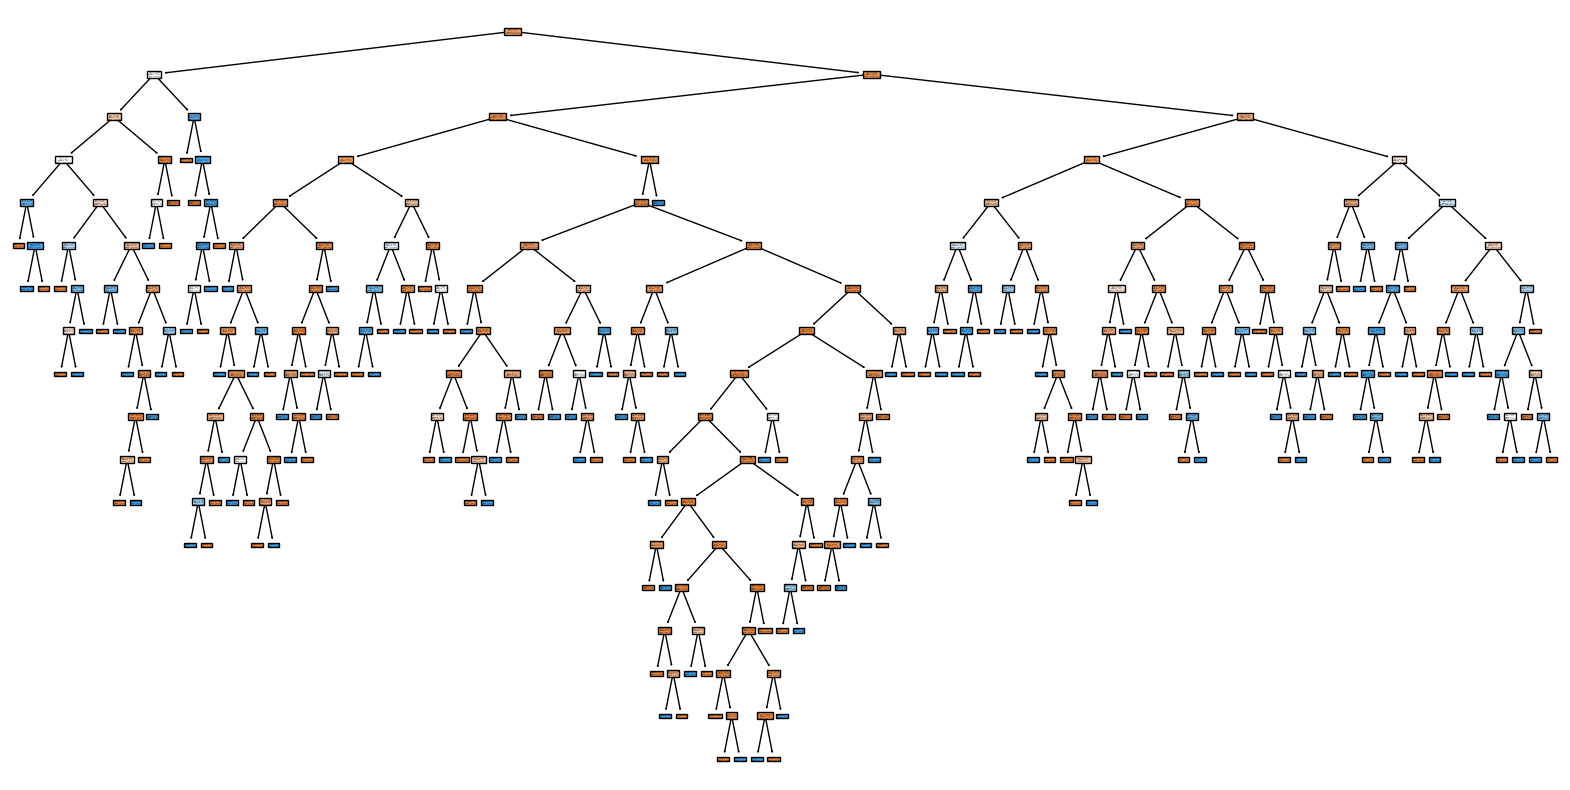

In [80]:
# Creamos el árbol de decisión
tree_model = DecisionTreeClassifier(random_state=SEED)
train_and_evaluate_model(tree_model, X_train, y_train, X_test, y_test)

# Dibujamos el árbol
fig = plt.figure(figsize=(20,10))
plot_tree(tree_model, filled=True)
plt.show()

### 6. Optimización de hiperparámetros para Árbol de Decisión

In [89]:
# Probamos con diferentes parámetros el Árbol de decisión

# Dividimos X_train en un subconjunto de entrenamiento y otro de validación
# Esto es para que el Grid Search use el eval para evaluar por que antes sino nos
# daba mucho overfiting y de esta forma lo evitamos.

X_train_sub, X_eval, y_train_sub, y_eval = train_test_split(
    X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)

# Definimos los hiperparámetros a probar esto creará 2000 modelos.
param_dist = {
    'max_depth': np.arange(1, 20, 2),
    'min_samples_split': np.arange(1, 10, 2),
    'min_samples_leaf': np.arange(1, 10, 2)
}

# Configuramos GridSearchCV
grid_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=SEED), param_dist, cv=5, scoring='balanced_accuracy'
)

# Ajustamos GridSearch solo con X_train_sub
grid_tree.fit(X_train_sub, y_train_sub)

# Mejor modelo encontrado
best_tree = grid_tree.best_estimator_
print(f"\nMejores hiperparámetros para Árbol de Decisión: {grid_tree.best_params_}")

# Evaluamos en el conjunto de validación
y_eval_pred = best_tree.predict(X_eval)
eval_score = balanced_accuracy_score(y_eval, y_eval_pred)
print(f"Balanced Accuracy en Validación: {eval_score:.2f}")

# Evaluación final en el test set
train_and_evaluate_model(best_tree, X_train, y_train, X_test, y_test)


Mejores hiperparámetros para Árbol de Decisión: {'max_depth': np.int64(15), 'min_samples_leaf': np.int64(1), 'min_samples_split': np.int64(3)}
Balanced Accuracy en Validación: 0.77

Modelo: DecisionTreeClassifier
Accuracy Balanceado: 0.73
Cross-validation mean: 0.78 ± 0.02


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
500 fits failed out of a total of 5000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
500 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/uti

DecisionTreeClassifier(max_depth=np.int64(15), min_samples_leaf=np.int64(1),
                       min_samples_split=np.int64(3), random_state=7)

In [90]:
# Mejora marginal del modelo base por ello hacemos un checkeo de overfitting
print("Train accuracy:", best_tree.score(X_train, y_train))
print("Test accuracy:", best_tree.score(X_test, y_test))

Train accuracy: 0.994413407821229
Test accuracy: 0.8692070030895983


Concluimos que hay overfiting incluso sin usar train para evaluar